# Test PPO et CPO par Omnisafe

In [ ]:
# Cell 1: Imports, configuration, and helper functions

import omnisafe
import safety_gymnasium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import glob

custom_cfgs = {
    'train_cfgs': {
        'total_steps': 10000000,
        'vector_env_nums': 16,
        'parallel': 1,
        'torch_threads': 1,
    },
    'algo_cfgs': {
        'steps_per_epoch': 50_000,
        'update_iters': 10,
    },
    'logger_cfgs': {
        'use_wandb': False,
        'save_model_freq': 10,
        'log_dir': './results/',
    },
}
env_id = 'SafetyPointGoal1-v0'

def find_seed_dir(base_dir, algo, env_id):
    pattern = os.path.join(base_dir, f"{algo}*{env_id}*")
    runs = glob.glob(pattern)
    if not runs:
        raise FileNotFoundError(f"No run folder matches {pattern}")

    run_dir = max(runs, key=os.path.getmtime)

    seed_dirs = [
        os.path.join(run_dir, d)
        for d in os.listdir(run_dir)
        if d.startswith('seed-') and os.path.isdir(os.path.join(run_dir, d))
    ]
    if not seed_dirs:
        raise FileNotFoundError(f"No seed subfolder under {run_dir}")

    most_recent_seed = max(seed_dirs, key=os.path.getmtime)
    return most_recent_seed

def load_from_csv(algo, env_id, base_dir='./results/'):
    seed_dir = find_seed_dir(base_dir, algo, env_id)
    csv_path = os.path.join(seed_dir, 'progress.csv')
    df = pd.read_csv(csv_path)
    reward_cols = [c for c in df.columns if 'EpRet' in c or 'Reward' in c]
    cost_cols   = [c for c in df.columns if 'EpCost' in c or 'Cost' in c]
    if not reward_cols or not cost_cols:
        print("Available columns:", df.columns.tolist())
        raise KeyError("Couldn't find reward or cost columns in progress.csv")
    rewards = df[reward_cols[0]].to_numpy()
    costs   = df[cost_cols[0]].to_numpy()
    return rewards, costs


In [ ]:
# Cell 2: Train PPO

ppo_agent = omnisafe.Agent('PPO', env_id=env_id, custom_cfgs=custom_cfgs)
ppo_agent.learn()


In [ ]:
# Cell 3: Train CPO

cpo_agent = omnisafe.Agent('CPO', env_id=env_id, custom_cfgs=custom_cfgs)
cpo_agent.learn()


PPO: 200 epochs loaded.
CPO: 200 epochs loaded.


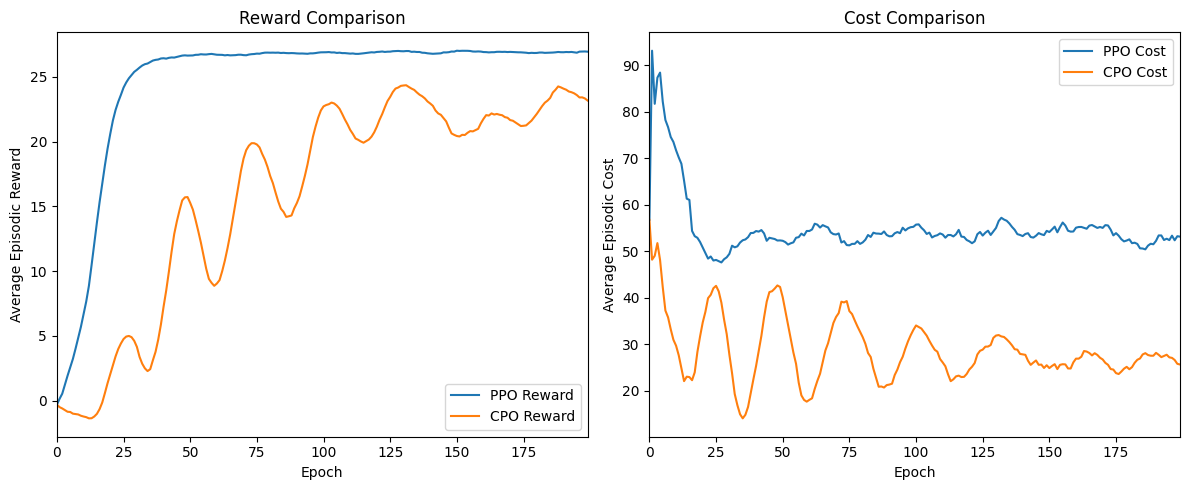

In [ ]:
# Cell 4: Plot PPO vs. CPO
ppo_rewards, ppo_costs = load_from_csv('PPO', env_id, base_dir=custom_cfgs['logger_cfgs']['log_dir'])
print(f"PPO: {len(ppo_rewards)} epochs loaded.")

cpo_rewards, cpo_costs = load_from_csv('CPO', env_id, base_dir=custom_cfgs['logger_cfgs']['log_dir'])
print(f"CPO: {len(cpo_rewards)} epochs loaded.")

max_epochs = max(len(ppo_rewards), len(cpo_rewards))
x_full = np.arange(max_epochs)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(np.arange(len(ppo_rewards)), ppo_rewards, label='PPO Reward')
plt.plot(np.arange(len(cpo_rewards)), cpo_rewards, label='CPO Reward')
plt.xlim(0, max_epochs - 1)
plt.xlabel('Epoch')
plt.ylabel('Average Episodic Reward')
plt.title('Reward Comparison')
plt.legend()

# Plot costs
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(ppo_costs)), ppo_costs, label='PPO Cost')
plt.plot(np.arange(len(cpo_costs)), cpo_costs, label='CPO Cost')
plt.xlim(0, max_epochs - 1)
plt.xlabel('Epoch')
plt.ylabel('Average Episodic Cost')
plt.title('Cost Comparison')
plt.legend()

plt.tight_layout()
plt.savefig('results/ppo_vs_cpo_comparison.png')
plt.show()

# Transition vers le monde réel

 seed-000-2025-05-02-17-32-12: epoch-90.pt
Episode 1 results:
Episode reward: 28.345465471982607
Episode cost: 98.0
Episode length: 1000.0
Episode 2 results:
Episode reward: 26.883881883910362
Episode cost: 94.0
Episode length: 1000.0
Episode 3 results:
Episode reward: 26.49601465152591
Episode cost: 111.0
Episode length: 1000.0
Episode 4 results:
Episode reward: 27.566487245785538
Episode cost: 91.0
Episode length: 1000.0
Episode 5 results:
Episode reward: 25.713005994664854
Episode cost: 66.0
Episode length: 1000.0
Episode 6 results:
Episode reward: 25.395945206591932
Episode cost: 0.0
Episode length: 1000.0
Episode 7 results:
Episode reward: 28.154285711927514
Episode cost: 71.0
Episode length: 1000.0
Episode 8 results:
Episode reward: 28.420210809657874
Episode cost: 95.0
Episode length: 1000.0
Episode 9 results:
Episode reward: 25.952541546957946
Episode cost: 60.0
Episode length: 1000.0
Episode 10 results:
Episode reward: 25.623887696870952
Episode cost: 56.0
Episode length: 1000

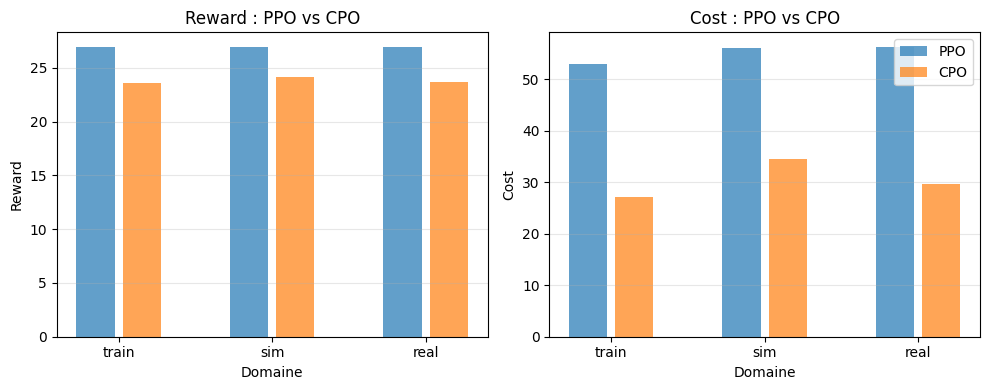

In [9]:
# Cell 5: Évaluation PPO / CPO (train, sim, real) via OmniSafe
import os, glob, warnings, pathlib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import defaultdict
import torch, gymnasium as gym, safety_gymnasium as sg, omnisafe
warnings.filterwarnings("ignore", category=UserWarning)

TAIL_EPOCHS = 10
ENV_ID      = "SafetyPointGoal1-v0"
ALGOS       = ("PPO","CPO")
RECORDS     = []

def newest_seed_dir(algo:str, env_id:str)->pathlib.Path:
    seeds = glob.glob(f"./results/{algo}-{{{env_id}}}/seed-*")
    if not seeds: raise FileNotFoundError("aucun seed-*")
    return pathlib.Path(max(seeds, key=os.path.getmtime))
def newest_ckpt(seed_dir:pathlib.Path)->pathlib.Path:
    ckpts = sorted(seed_dir.glob("torch_save/*.pt"))
    if not ckpts: raise FileNotFoundError("aucun .pt")
    return ckpts[-1]
def training_stats(seed_dir:pathlib.Path, tail=TAIL_EPOCHS):
    df = pd.read_csv(seed_dir/"progress.csv").tail(tail)
    return df["Metrics/EpRet"].mean(), df["Metrics/EpCost"].mean()

class RealWorldWrapper(gym.Wrapper):
    def __init__(self, env, d=2, n=0.05, f=0.1):
        super().__init__(env); self.d,self.n,self.f=d,n,f; self.buf=[]
    def reset(self, **kw):
        self.buf=[np.zeros(self.action_space.shape)]*self.d
        obs,info=self.env.reset(**kw); return obs+self._noise(), info
    def step(self, a):
        self.buf.append(a); act=self.buf.pop(0)
        try: self.env.unwrapped.sim.data.xfrc_applied[0]=np.random.normal(0,self.f,6)
        except Exception: pass
        out=self.env.step(act)
        if len(out)==6: obs,r,c,done,trunc,info=out; info=dict(info); info['cost']=c
        else:           obs,r,done,trunc,info=out
        return obs+self._noise(), r, done, trunc, info
    def _noise(self): return np.random.normal(0,self.n,self.observation_space.shape)

def omni_evaluate(seed_dir:pathlib.Path, env:gym.Env, episodes=100):
    ckpt=newest_ckpt(seed_dir)
    print(f" {seed_dir.name}: {ckpt.name}")
    ev=omnisafe.Evaluator(env=env, render_mode='rgb_array')
    ev.load_saved(save_dir=str(seed_dir), model_name=ckpt.name,
                  camera_name=None,width=0,height=0)
    res=ev.evaluate(num_episodes=episodes)

    if isinstance(res, dict):
        returns, costs = res["Return"], res["Cost"]
    else:
        returns, costs = res
    returns, costs = np.asarray(returns), np.asarray(costs)
    return returns.mean(), costs.mean(), np.mean((costs>25).astype(float))

for algo in ALGOS:
    seed=newest_seed_dir(algo,ENV_ID)
    r,c=training_stats(seed)
    RECORDS.append(dict(algo=algo,domain="train",reward=r,cost=c,viol=np.nan))

sim_env=sg.make(ENV_ID)
for algo in ALGOS:
    seed=newest_seed_dir(algo,ENV_ID)
    r,c,v=omni_evaluate(seed, sim_env, 100)
    RECORDS.append(dict(algo=algo,domain="sim",reward=r,cost=c,viol=v))
sim_env.close()

real_env=RealWorldWrapper(sg.make(ENV_ID))
for algo in ALGOS:
    seed=newest_seed_dir(algo,ENV_ID)
    r,c,v=omni_evaluate(seed, real_env, 100)
    RECORDS.append(dict(algo=algo,domain="real",reward=r,cost=c,viol=v))
real_env.close()

df=pd.DataFrame(RECORDS)
print("\n==== Tableau récapitulatif ====\n",
      df.pivot(index='algo',columns='domain',
               values=['reward','cost','viol']).round(2))

plt.figure(figsize=(10,4))
domains=['train','sim','real']; x=np.arange(len(domains))
for i,var in enumerate(("reward","cost")):
    plt.subplot(1,2,i+1)
    for j,algo in enumerate(ALGOS):
        vals=df[df.algo==algo].set_index('domain')[var].loc[domains]
        plt.bar(x+0.3*j,vals,width=0.25,label=algo,alpha=0.7)
    plt.xticks(x+0.15,domains); plt.xlabel("Domaine"); plt.ylabel(var.capitalize())
    plt.title(f"{var.capitalize()} : PPO vs CPO"); plt.grid(True,axis='y',alpha=0.3)
plt.legend(); plt.tight_layout(); plt.show()
